# 질의 응답(Question Answering, QA)

<br>


## 메모리 네트워크(Memory Network, MemN)를 이용한 영어 QA

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

<br>


### `Babi` 데이터 로드

In [2]:
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
                'babi_tasks_1-20_v1-2.tar.gz')

11745123/11745123 [==============================] - 2s 0us/step


In [3]:
with tarfile.open(path) as tar:
 tar.extractall()
 tar.close()

DATA_DIR = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

<br>

### Babi 데이터셋 확인
- `Babi` 데이터셋은 아래와 같은 형식
- `ID`는 각 문장의 번호
```
ID text
ID text
ID text
ID question[tab]answer[tab]supporting_fact ID.
...
```
<br>

- 4개의 문장으로 구성된 스토리가 있을 때
```
1 Sandra travelled to the kitchen.
2 Sandra travelled to the hallway.
3 Mary went to the bathroom.
4 Sandra moved to the garden.
```

- 4개의 문장으로 구성된 스토리를 기반으로 질문과 정답이 나옴
```
5 Where is Sandra?      Garden         4
```


<br>

- Garden 옆의 숫자 4는 `Supporting fact`

  실제 정답이 주어진 스토리에서 몇 번 ID 문장에 있었는지 알려줌

  **모델 학습 단계에서는 학습에서 제외함**

<br>

#### `Babi` 데이터셋
- 첫번째 스토리는 ID가 15번까지 이어짐

  $→$ 중간에 질문은 3번, 6번, 9번, 11번, 15번으로 다섯 번

  **질문이 한 번 나왔다고 해서 스토리가 끝나는 것이 아님**

  - 스토리는 계속 이어지고 질문도 계속 이어짐


In [4]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
      break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


<br>

## 메모리 네트워크 구조

<img src='https://wikidocs.net/images/page/82475/memn.PNG'>

- 위 그림은 메모리 네트워크 구조를 간단히 표현한 그림
1. **그림의 가장 상단에는 스토리 문장과 질문 문장, 두 개의 입력이 들어옴**
    
  **이 두 문장은 각각의 임베딩 과정을 거침**

2. **스토리 문장은 Embedding C를 통해서 임베딩이 되고, 질문 문장은 Embedding B를 통해서 임베딩이 진행**
  
  **여기서 임베딩이란 문장 내 각 단어가 임베딩이 되어, 각 단어가 임베딩 벡터로 변환된 문장을 얻는다는 의미**

3. **임베딩이 된 두 개의 문장은 내적(dot product)을 통해 각 단어 간 유사도를 구하고,**

  $\rightarrow$ **이렇게 구해진 유사도는 소프트맥스 함수를 지나서 Embedding A로 임베딩이 된 스토리 문장에 더해짐**
  
  (위 그림에서 '덧셈'이라고 적혀있는 부분까지 연산이 진행된 상태)
  
  (Embedding A, B, C는 각각 별 개의 임베딩 층(Embedding layer))

<br>




#### 다른 관점의 설명
- **스토리 문장을 Value와 Key라고 하고, 질문 문장을 Query라고 할 때,**
  
  **Query는 Key와 유사도를 구하고, 소프트맥스 함수를 통해 값을 정규화하여 Value에 더해서 이 유사도값을 반영**
  
  $→$ **연산 과정은 어텐션 메커니즘의 의도를 가지고 있음**

<br>

- **위 그림에서 '덧셈'이라고 적혀있는 부분까지의 연산은**
  
  **어텐션 메커니즘을 통해서 질문 문장과의 유사도를 반영한, 스토리 문장 표현을 얻기 위한 과정**
  
  $→$ 이 스토리 문장 표현을, 질문 문장을 임베딩한 질문 표현과 연결(concatenate)
  
  $\rightarrow$ 그리고 이 표현을 LSTM과 밀집층(dense layer)의 입력으로 사용하여 정답을 예측


<br>

### Babi 데이터셋 전처리

<br>

#### 스퇼, 질문, 답변을 별도로 저장

In [5]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 리스트
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [6]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [7]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [8]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [9]:
train_stories[3576]

['John went back to the garden.',
 'Mary went to the kitchen.',
 'Sandra went back to the bedroom.',
 'John travelled to the bedroom.']

In [10]:
train_questions[3576]

'Where is John? '

In [11]:
train_answers[3576]

'bedroom'

<br>

### 단어 집합 생성 및 토큰화 및 스토리와 질문의 최대 길이 계산  
- 스토리는 모두 펼쳐서 하나의 샘플로 처리

In [12]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]

In [13]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1

        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1

        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [14]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [15]:
print(word2idx)

{'to': 1, 'the': 2, '.': 3, 'went': 4, 'Sandra': 5, 'John': 6, 'Daniel': 7, 'Mary': 8, 'travelled': 9, 'journeyed': 10, 'back': 11, 'bathroom': 12, 'garden': 13, 'hallway': 14, 'moved': 15, 'office': 16, 'kitchen': 17, 'bedroom': 18, 'Where': 19, 'is': 20, '?': 21}


In [16]:
vocab_size = len(word2idx) + 1

In [17]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 68
질문의 최대 길이 : 4


<br>

### 정수 인코딩 및 패딩

In [18]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [19]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [20]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


In [21]:
Xstrain[3576]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  6,  4, 11,  1,  2, 13,  3,  8,  4,
        1,  2, 17,  3,  5,  4, 11,  1,  2, 18,  3,  6,  9,  1,  2, 18,  3],
      dtype=int32)

In [22]:
Xqtrain[3576]

array([19, 20,  6, 21], dtype=int32)

In [23]:
Ytrain[3576]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0.], dtype=float32)

<br>

### 메모리 네트워크 구현

In [40]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
from tensorflow.keras.utils import plot_model

In [25]:
train_epochs = 120 # 에포크 횟수
batch_size = 32 # 배치 크기
embed_size = 50 # 임베딩 크기
lstm_size = 64 # LSTM의 크기
dropout_rate = 0.30 # 드롭아웃 적용 비율

<br>

### 모델 설계

- 입력층

In [26]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


- 스토리를 위한 첫번째 임베딩층 (그림에서의 Embedding A)

In [ ]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))

- 스토리를 위한 두번째 임베딩층. (Embedding C)
  - 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로

In [27]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))

- 질문을 위한 임베딩층 (Embedding B)

In [28]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))

- 임베딩 과정 확인

In [29]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


<br>

- 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
  - 유사도는 내적을 사용

In [30]:
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


<br>

- 유사도가 반영된 어텐션 분포 행렬과 임베딩 C를 거친 스토리 행렬을 더함
  - **이로부터 얻은 행렬은 어텐션 값 행렬(Attention Value Matrix)**

In [31]:
response = add([match, input_encoded_c])

In [32]:
# 질문 행렬은 (4, 50)의 크기를 가진다.
# 하지만 어텐션 값 행렬의 크기는 (68, 4)이다.
# 이 두 개를 연결시켜주기 위해서 어텐션 값 행렬의 크기를 (4, 68)로 변환해준다.
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# 질문 행렬과 어텐션 값 행렬을 연결한다.
# (4, 118)의 크기를 가진다.
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [33]:
answer = LSTM(lstm_size)(answer)
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 68)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 50)             1100      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 4, 50)                1100      ['input_2[0][0]']             
                                                                                            

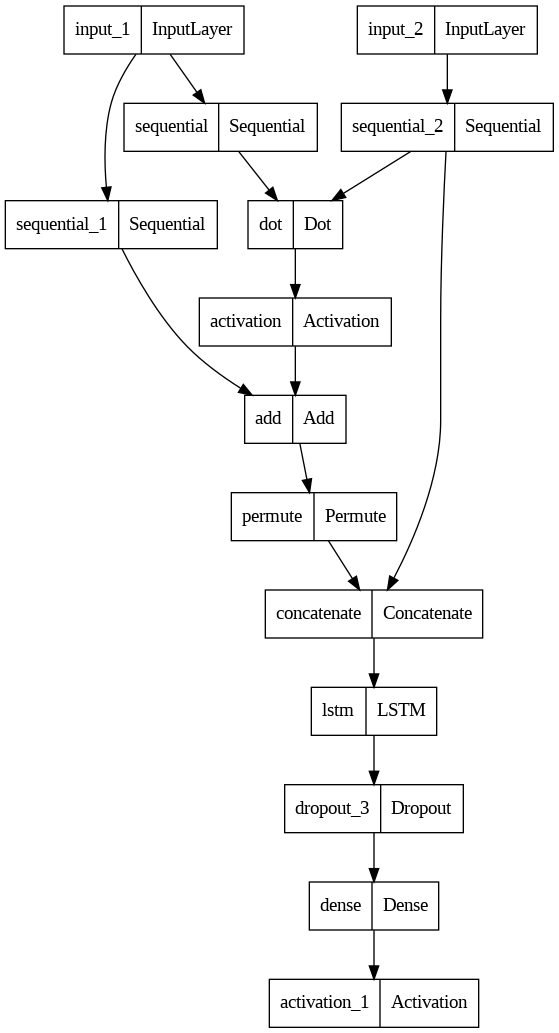

In [41]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())
plot_model(model)

<br>

### 모델 학습

In [36]:
history = model.fit([Xstrain, Xqtrain], Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest), verbose=False)

- 모델 저장

In [37]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 7ms/step - loss: 0.3169 - acc: 0.9210

 테스트 정확도: 0.9210


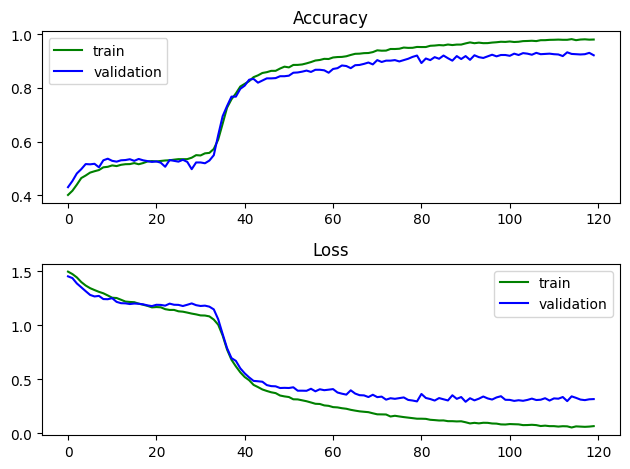

32/32 [==============================] - 1s 3ms/step


In [39]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

ytest = np.argmax(Ytest, axis=1)

Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [42]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
Where is John ?     : hallway hallway
Where is Mary ?     : bathroom bathroom
Where is Sandra ?   : kitchen kitchen
Where is Sandra ?   : hallway hallway
Where is Sandra ?   : kitchen kitchen
Where is Sandra ?   : hallway hallway
Where is Sandra ?   : garden  garden
Where is Daniel ?   : hallway hallway
Where is Sandra ?   : office  office
Where is Daniel ?   : office  hallway
Where is Mary ?     : kitchen kitchen
Where is Mary ?     : garden  garden
Where is Daniel ?   : office  office
Where is Mary ?     : bedroom bedroom
Where is Mary ?     : bedroom bedroom
Where is John ?     : kitchen kitchen
Where is John ?     : garden  garden
Where is John ?     : kitchen kitchen
Where is Daniel ?   : office  office
Where is John ?     : kitchen hallway
Where is Mary ?     : hallway hallway
Where is John ?     : office  office
Where is John ?     : office  office
Where is Sandra ?   : hallway bathroom
Where is Daniel ?   : be